## 8 - Hierarchical Clustering
## Table of Contents
<ul>
<li><a href="#1">Extracting Feature Vectors</a></li>
<li><a href="#2">Distance Matrix</a></li>
<li><a href="#3">Implementing Hierarchical Clustering</a></li>
<li><a href="#4">Checking the cluster's metrics</a></li>
</ul>

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [68]:
df_fractures = pd.read_csv("./output/df_fractures_4.csv")

df_fractures.head()

,fracture_id,segments,segments_color,segments_width,Xmin,Xmax,Ymin,Ymax,fracture_height,fracture_length,fracture_direction,total_size,w_average_angle_degree,w_average_brightness
0,0,"2799.9979,2886.5779,2715.0032,2797.5709,2704.0...",yellow,3,2704.0042,2799.9979,2726.5764,2886.5779,160.0015,95.9937,Vertical,194.911960,59.174355,164.262832
1,1,"2857.0003,2830.5703,2759.9982,2772.5739,2755.0...",blue,3,2755.0029,2857.0003,2736.5771,2830.5703,93.9932,101.9974,Horizontal,149.359400,43.338584,155.376969
2,2,"2612.9964,2824.5755,2708.7733,2805.8089",blue,3,2612.9964,2708.7733,2805.8089,2824.5755,18.7666,95.7769,Horizontal,97.598155,168.913872,152.000000
3,3,"2655.0037,2794.5735,2613.9955,2756.5784",blue,3,2613.9955,2655.0037,2756.5784,2794.5735,37.9951,41.0082,Horizontal,55.904383,42.815860,160.000000
4,4,"3004.443,2762.0149,3084.76,2774.2514,3121.4356...",blue,3,3004.4430,3121.4356,2762.0149,2778.0103,15.9954,116.9926,Horizontal,118.111506,7.785202,171.300731


In [69]:
# reading the image grayscale
image = cv2.imread('Global_20190321_ShapeV20_200kfacets_FB3.png', cv2.IMREAD_GRAYSCALE)

image = cv2.flip(image, 0)

<a id='1'></a>
### Extracting Histograms

In [70]:
# check number of fractures that their height or length are less than 1px
# which needs manual fix while cropping
# we will be padding extra pixels to the bounding box later, to extract enough pixels

df_fractures.loc[(df_fractures['fracture_height'] < 1) | (df_fractures['fracture_length'] < 1)].shape[0]

22

There are 22 fractures, we will add a condition to extend the bounding box by 5 pixels

In [71]:
def crop_hist(index, plot=False):

    Xmin, Xmax, Ymin, Ymax = int(df_fractures['Xmin'][index]), int(df_fractures['Xmax'][index]), int(
        df_fractures['Ymin'][index]), int(df_fractures['Ymax'][index])

    fracture_height = int(df_fractures['fracture_height'][index])
    fracture_length = int(df_fractures['fracture_length'][index])

    # Extending the frame 5 pixels if the fracture is completely horizontal or vertical
    if fracture_height < 1:
        Ymin = Ymin - 5
        Ymax = Ymax + 5

    if fracture_length < 1:
        Xmin = Xmin - 5
        Xmax = Xmax + 5

    cropped_image = image[Ymin:Ymax, Xmin:Xmax]

    number_of_bins = 10
    hist_values = np.histogram(cropped_image.ravel(), number_of_bins, [
                               0, 256], density=True)[0] # normalise histogram instead of using MinMaxScaling

    if plot == True:

        fig = plt.figure(figsize=(9, 3))

        rows, columns = 1, 3

        fig.add_subplot(rows, columns, 1)

        plt.imshow(cropped_image, cmap="gray")
        plt.axis('off')
        plt.title("Cropped Image")

        fig.add_subplot(rows, columns, 2)

        plt.hist(cropped_image.ravel(), number_of_bins, [0, 256])
        plt.title("Histogram")

        fig.add_subplot(rows, columns, 3)

        plt.hist(cropped_image.ravel(), number_of_bins,
                 [0, 256], density=True, color="black")
        plt.title("Normalised Histogram")

        fig.tight_layout()
        plt.show()

    return hist_values

An example for extracting histogram where the image can't be cropped, because of the height or length pixel being non-existent, and extending the bounding box by 5 pixels to see the crack

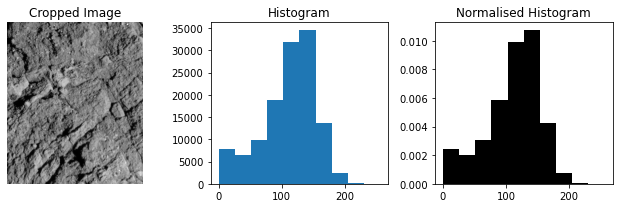

array([2.42439717e-03, 1.99033479e-03, 3.07860452e-03, 5.88817756e-03,
       9.90403298e-03, 1.07519181e-02, 4.25686279e-03, 7.30806596e-04,
       2.77127342e-05, 9.65275010e-06])

In [72]:
crop_hist(1357, plot = True)

In [73]:
# number of fractures
n = df_fractures.shape[0]
n

1529

<a id='2'></a>
### Distance Matrix


In [74]:
# create the distance matrix
distance_matrix = np.zeros((n, n))

# Iterate over the dataframe find histogram values
# compare each histogram to all histograms and fill in the distance matrix

for i in range(n):

    histogram_i = crop_hist(i)

    # removing first two bins to filter the shadow
    histogram_i = histogram_i[2:]

    for k in range(i):
        histogram_k = crop_hist(k)

        # removing first two bins to filter the shadow
        histogram_k = histogram_k[2:]

        #distance_matrix[i, k] = cv2.compareHist(histogram_i, histogram_k, cv2.HISTCMP_CHISQR)
        distance_matrix[i, k] = distance.jensenshannon(histogram_i, histogram_k)

In [75]:
distance_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07072602, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17741582, 0.20077625, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.30937667, 0.32015417, 0.43604644, ..., 0.        , 0.        ,
        0.        ],
       [0.52789929, 0.53376127, 0.60018189, ..., 0.31920256, 0.        ,
        0.        ],
       [0.46107162, 0.48117889, 0.48768791, ..., 0.32488953, 0.26254135,
        0.        ]])

In [76]:
# symmetrize the distance matrix
distance_matrix = np.maximum(distance_matrix, distance_matrix.transpose())

# convert the redundant n*n square matrix form into a condensed nC2 array
cond_distance_matrix = distance.squareform(distance_matrix)

In [77]:
distance_matrix

array([[0.        , 0.07072602, 0.17741582, ..., 0.30937667, 0.52789929,
        0.46107162],
       [0.07072602, 0.        , 0.20077625, ..., 0.32015417, 0.53376127,
        0.48117889],
       [0.17741582, 0.20077625, 0.        , ..., 0.43604644, 0.60018189,
        0.48768791],
       ...,
       [0.30937667, 0.32015417, 0.43604644, ..., 0.        , 0.31920256,
        0.32488953],
       [0.52789929, 0.53376127, 0.60018189, ..., 0.31920256, 0.        ,
        0.26254135],
       [0.46107162, 0.48117889, 0.48768791, ..., 0.32488953, 0.26254135,
        0.        ]])

In [78]:
cond_distance_matrix

array([0.07072602, 0.17741582, 0.12562507, ..., 0.31920256, 0.32488953,
       0.26254135])

<a id='3'></a>
### Implementing Hierarchical Clustering

In [79]:
Z = linkage(cond_distance_matrix, method='ward')

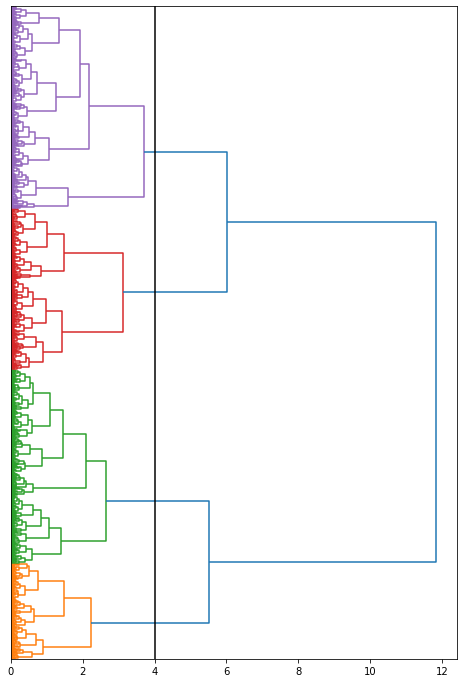

In [80]:
cut_tree_level = 4

plt.figure(figsize=(8,12))

dendrogram(Z, color_threshold=cut_tree_level, show_leaf_counts=True, orientation='right', no_labels=True)

plt.axvline(x=cut_tree_level, c='k')

plt.show()

In [81]:
# cut the dendrogram
labels = cut_tree(Z, height = cut_tree_level)

# assign the labels (the id of the cluster) to the dataframe as a new column
df_fractures['hc_cluster_id'] = labels

df_fractures.head()

,fracture_id,segments,segments_color,segments_width,Xmin,Xmax,Ymin,Ymax,fracture_height,fracture_length,fracture_direction,total_size,w_average_angle_degree,w_average_brightness,hc_cluster_id
0,0,"2799.9979,2886.5779,2715.0032,2797.5709,2704.0...",yellow,3,2704.0042,2799.9979,2726.5764,2886.5779,160.0015,95.9937,Vertical,194.911960,59.174355,164.262832,0
1,1,"2857.0003,2830.5703,2759.9982,2772.5739,2755.0...",blue,3,2755.0029,2857.0003,2736.5771,2830.5703,93.9932,101.9974,Horizontal,149.359400,43.338584,155.376969,0
2,2,"2612.9964,2824.5755,2708.7733,2805.8089",blue,3,2612.9964,2708.7733,2805.8089,2824.5755,18.7666,95.7769,Horizontal,97.598155,168.913872,152.000000,1
3,3,"2655.0037,2794.5735,2613.9955,2756.5784",blue,3,2613.9955,2655.0037,2756.5784,2794.5735,37.9951,41.0082,Horizontal,55.904383,42.815860,160.000000,0
4,4,"3004.443,2762.0149,3084.76,2774.2514,3121.4356...",blue,3,3004.4430,3121.4356,2762.0149,2778.0103,15.9954,116.9926,Horizontal,118.111506,7.785202,171.300731,0


In [82]:
df_fractures.loc[df_fractures.hc_cluster_id == 0, "segments_color"] = "red"
df_fractures.loc[df_fractures.hc_cluster_id == 1, "segments_color"] = "green"
df_fractures.loc[df_fractures.hc_cluster_id == 2, "segments_color"] = "blue"
df_fractures.loc[df_fractures.hc_cluster_id == 3, "segments_color"] = "yellow"

df_fractures.head()

,fracture_id,segments,segments_color,segments_width,Xmin,Xmax,Ymin,Ymax,fracture_height,fracture_length,fracture_direction,total_size,w_average_angle_degree,w_average_brightness,hc_cluster_id
0,0,"2799.9979,2886.5779,2715.0032,2797.5709,2704.0...",red,3,2704.0042,2799.9979,2726.5764,2886.5779,160.0015,95.9937,Vertical,194.911960,59.174355,164.262832,0
1,1,"2857.0003,2830.5703,2759.9982,2772.5739,2755.0...",red,3,2755.0029,2857.0003,2736.5771,2830.5703,93.9932,101.9974,Horizontal,149.359400,43.338584,155.376969,0
2,2,"2612.9964,2824.5755,2708.7733,2805.8089",green,3,2612.9964,2708.7733,2805.8089,2824.5755,18.7666,95.7769,Horizontal,97.598155,168.913872,152.000000,1
3,3,"2655.0037,2794.5735,2613.9955,2756.5784",red,3,2613.9955,2655.0037,2756.5784,2794.5735,37.9951,41.0082,Horizontal,55.904383,42.815860,160.000000,0
4,4,"3004.443,2762.0149,3084.76,2774.2514,3121.4356...",red,3,3004.4430,3121.4356,2762.0149,2778.0103,15.9954,116.9926,Horizontal,118.111506,7.785202,171.300731,0


In [83]:
# reading the image
image = cv2.imread('Global_20190321_ShapeV20_200kfacets_FB3.png')
image = cv2.flip(image, 0)

# draw lines
for index, row in df_fractures.iterrows():

    # Read segment attribute from the df
    s_segments = row['segments']

    # Converting the string to list
    l_segments = s_segments.split(",")

    # Extract each line's coordinates, color and draw on the image
    for x in range(0, (len(l_segments) - 3), 2):

        X1, Y1, X2, Y2 = int(float(l_segments[x])), int(
            float(l_segments[x+1])), int(float(l_segments[x+2])), int(float(l_segments[x+3]))

        start_point = (X1, Y1)
        end_point = (X2, Y2)

        if row['segments_color'] == 'red':
            # Red color in BGR
            color = (0, 0, 255)
        elif row['segments_color'] == 'green':
            # Green color in BGR
            color = (0, 255, 0)
        elif row['segments_color'] == 'blue':
            # Blue color in BGR
            color = (255, 0, 0)
        elif row['segments_color'] == 'yellow':
            # Yellow color in BGR
            color = (0, 255, 255)
        else:
            # White color in BGR
            color = (255, 255, 255)

        # Line thickness
        thickness = 3

        image = cv2.line(image, start_point, end_point, color, thickness)

# flip the image again and write image in a new jpg file
image = cv2.flip(image, 0)
cv2.imwrite('./output/bennu_hc_clusters.jpg', image)

True

<a id='4'></a>
### Checking the cluster's metrics

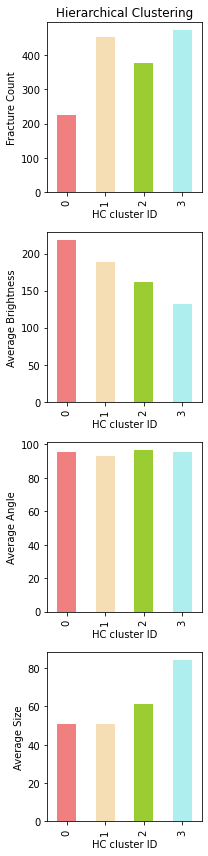

In [89]:
plt.figure(figsize=(3, 12))

order = [3, 2, 0, 1]

new_cluster_ids = [0, 1, 2, 3]

bar_colors=['lightcoral', 'wheat', 'yellowgreen', 'paleturquoise', 'plum']

plt.subplot(4, 1, 1)
ax1 = df_fractures.groupby('hc_cluster_id')['hc_cluster_id'].count().loc[order].plot(kind='bar', color=bar_colors)
ax1.set_title('Hierarchical Clustering')
ax1.set_xlabel("HC cluster ID")
ax1.set_ylabel("Fracture Count")
# renmae cluster IDs
ax1.set_xticklabels(new_cluster_ids)

plt.subplot(4, 1, 2)
ax2 = df_fractures.groupby('hc_cluster_id')['w_average_brightness'].mean().loc[order].plot(kind='bar', color=bar_colors)
ax2.set_xlabel("HC cluster ID")
ax2.set_ylabel("Average Brightness")
# renmae cluster IDs
ax2.set_xticklabels(new_cluster_ids)

plt.subplot(4, 1, 3)
ax3 = df_fractures.groupby('hc_cluster_id')['w_average_angle_degree'].mean().loc[order].plot(kind='bar', color=bar_colors)
ax3.set_xlabel("HC cluster ID")
ax3.set_ylabel("Average Angle")
# renmae cluster IDs
ax3.set_xticklabels(new_cluster_ids)

plt.subplot(4, 1, 4)
ax4 = df_fractures.groupby('hc_cluster_id')['total_size'].mean().loc[order].plot(kind='bar', color=bar_colors)
ax4.set_xlabel("HC cluster ID")
ax4.set_ylabel("Average Size")
# renmae cluster IDs
ax4.set_xticklabels(new_cluster_ids)

plt.tight_layout()
plt.show()

In [90]:
df_clusters_stats = df_fractures.groupby('hc_cluster_id')['w_average_brightness', 'w_average_angle_degree', 'total_size'].mean()

df_clusters_stats['count'] =  df_fractures.groupby('hc_cluster_id')['hc_cluster_id'].count().to_frame()

# rename cluster IDs
# renmae cluster IDs
df_clusters_stats.hc_cluster_id = new_cluster_ids

df_clusters_stats

C:\Users\saram\AppData\Local\Temp\ipykernel_15640\1183917644.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_clusters_stats = df_fractures.groupby('hc_cluster_id')['w_average_brightness', 'w_average_angle_degree', 'total_size'].mean()
C:\Users\saram\AppData\Local\Temp\ipykernel_15640\1183917644.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_clusters_stats.hc_cluster_id = new_cluster_ids


,w_average_brightness,w_average_angle_degree,total_size,count
hc_cluster_id,,,,
0,162.085565,96.659599,61.227925,378
1,132.574859,95.636314,84.262147,472
2,188.911016,92.863573,50.997154,454
3,217.886470,95.678806,50.824412,225
